# Profiling skforecast

This document shows the profiling of the main classes, methods and functions available in skforecast. Understanding the bottlenecks will help to:

+ Use it more efficiently
+ Improve the code for future releases

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform
import psutil

import sklearn
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster

%load_ext pyinstrument

In [2]:
# Versions
# ==============================================================================
print(f"Python version      : {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version  : {skforecast.__version__}")
print(f"pandas version      : {pd.__version__}")
print(f"numpy version       : {np.__version__}")
print(f"psutil version      : {psutil.__version__}")
print("")

# System information
# ==============================================================================
print(f"Machine type: {platform.machine()}")
print(f"Processor type: {platform.processor()}")
print(f"Platform type: {platform.platform()}")
print(f"Operating system: {platform.system()}")
print(f"Operating system release: {platform.release()}")
print(f"Operating system version: {platform.version()}")
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

Python version      : 3.12.9
scikit-learn version: 1.5.2
skforecast version  : 0.15.0
pandas version      : 2.2.3
numpy version       : 1.26.4
psutil version      : 7.0.0

Machine type: x86_64
Processor type: x86_64
Platform type: Linux-5.15.0-1077-aws-x86_64-with-glibc2.31
Operating system: Linux
Operating system release: 5.15.0-1077-aws
Operating system version: #84~20.04.1-Ubuntu SMP Mon Jan 20 22:14:54 UTC 2025
Number of physical cores: 4
Number of logical cores: 8


A time series of length 1000 with random values is created.

In [3]:
# Data
# ==============================================================================
np.random.seed(123)
n = 1_000
data = pd.Series(data = np.random.normal(size=n))

## Dummy regressor

To isolate the training process of the regressor from the other parts of the code, a dummy regressor class is created. This dummy regressor has a fit method that does nothing, and a predict method that returns a constant value.

In [4]:
class DummyRegressor(LinearRegression):
    """
    Dummy regressor with dummy fit and predict methods.
    """
    
    def fit(self, X, y):
        pass

    def predict(self, y):
        predictions = np.ones(shape = len(y))
        return predictions

## Profiling fit

_     ._   __/__   _ _  _  _ _/_   Recorded: 14:42:53  Samples:  4
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.005     CPU time: 0.006
/   _/                      v5.0.1

Cell [5]

0.004 <module>  /tmp/ipykernel_16301/930535467.py:1
`- 0.004 ForecasterRecursive.fit  skforecast/recursive/_forecaster_recursive.py:902
      [13 frames hidden]  skforecast, pandas, numpy
         0.001 ForecasterRecursive._create_lags  skforecast/recursive/_forecaster_recursive.py:464
         0.001 SingleBlockManager.__init__  pandas/core/internals/managers.py:1837
         0.002 ForecasterRecursive._binning_in_sample_residuals  skforecast/recursive/_forecaster_recursive.py:1018
         `- 0.001 [self]  skforecast/recursive/_forecaster_recursive.py
            0.001 _quantile  numpy/lib/function_base.py:4765
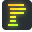

In [5]:
%%pyinstrument

forecaster = ForecasterRecursive(
                 regressor = DummyRegressor(),
                 lags      = 24
             )

forecaster.fit(y=data)

Almost all of the time spent by `fit` is required by the `create_train_X_y` method.

_     ._   __/__   _ _  _  _ _/_   Recorded: 14:42:53  Samples:  100
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.164     CPU time: 0.296
/   _/                      v5.0.1

Cell [6]

0.164 <module>  /tmp/ipykernel_16301/2499331845.py:1
`- 0.163 ForecasterRecursive.fit  skforecast/recursive/_forecaster_recursive.py:902
      [53 frames hidden]  sklearn, numpy, joblib, subprocess, s...
         0.063 ndarray.partition  <built-in>
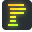

In [6]:
%%pyinstrument

forecaster = ForecasterRecursive(
                 regressor = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                 lags      = 24
             )

forecaster.fit(y=data)

When training a forecaster with a real machine learning regressor, the time spent by `create_train_X_y` is negligible compared to the time needed by the `fit` method of the regressor. Therefore, improving the speed of `create_train_X_y` will not have much impact.

## Profiling create_train_X_y

Understand how the `create_train_X_y` method is influenced by the length of the series and the number of lags. 

In [7]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
n_lags = [5, 10, 50, 100, 200]
results = {}

for lags in n_lags:
    execution_time = []
    forecaster = ForecasterRecursive(
                     regressor = DummyRegressor(),
                     lags      = lags
                 )

    for n in series_length:
        y = pd.Series(data = np.random.normal(size=n))
        tic = time.perf_counter()
        _ = forecaster.create_train_X_y(y=y)
        toc = time.perf_counter()
        execution_time.append(toc - tic)

    results[lags] = execution_time

results = pd.DataFrame(
              data = results,
              index = series_length
          )

results

,5,10,50,100,200
1000,0.000890,0.000957,0.001248,0.002070,0.003482
250750,0.006234,0.006186,0.033500,0.063247,0.123518
500500,0.011425,0.018634,0.064680,0.126329,0.250267
750250,0.016728,0.023954,0.102774,0.200989,0.402883
1000000,0.016318,0.027664,0.107433,0.211251,0.425320


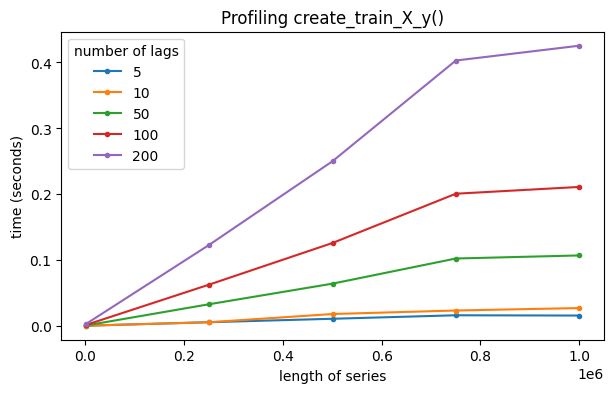

In [8]:
fig, ax = plt.subplots(figsize=(7, 4))
results.plot(ax=ax, marker='.')
ax.set_xlabel('length of series')
ax.set_ylabel('time (seconds)')
ax.set_title('Profiling create_train_X_y()')
ax.legend(title='number of lags');

## Profiling predict

In [9]:
forecaster = ForecasterRecursive(
                 regressor = DummyRegressor(),
                 lags      = 24
             )

forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 14:42:56  Samples:  38
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.044     CPU time: 0.050
/   _/                      v5.0.1

Cell [10]

0.043 <module>  /tmp/ipykernel_16301/3639615597.py:1
|- 0.037 ForecasterRecursive.predict  skforecast/recursive/_forecaster_recursive.py:1405
|     [10 frames hidden]  <built-in>, skforecast, pandas, warnings
|        0.035 ForecasterRecursive._recursive_predict  skforecast/recursive/_forecaster_recursive.py:1226
|        |- 0.024 [self]  skforecast/recursive/_forecaster_recursive.py
|        `- 0.010 DummyRegressor.predict  /tmp/ipykernel_16301/4114816888.py:9
|           |- 0.008 ones  numpy/core/numeric.py:136
|           |     [2 frames hidden]  numpy, <built-in>
|           |- 0.001 [self]  /tmp/ipykernel_16301/4114816888.py
|           `- 0.001 len  <built-in>
`- 0.006 [self]  /tmp/ipykernel_16301/3639615597.py
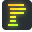

In [10]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

In [11]:
forecaster = ForecasterRecursive(
                 regressor = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                 lags      = 24
             )

forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 14:42:56  Samples:  510
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.513     CPU time: 1.993
/   _/                      v5.0.1

Cell [12]

0.512 <module>  /tmp/ipykernel_16301/3639615597.py:1
`- 0.512 ForecasterRecursive.predict  skforecast/recursive/_forecaster_recursive.py:1405
      [12 frames hidden]  skforecast, sklearn, <built-in>
         0.412 HistGradientBoostingRegressor._predict_iterations  sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1297
         |- 0.230 TreePredictor.predict  sklearn/ensemble/_hist_gradient_boosting/predictor.py:45
         |  `- 0.211 [self]  sklearn/ensemble/_hist_gradient_boosting/predictor.py
         `- 0.182 [self]  sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py
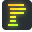

In [12]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

Inside the `predict` method, the `append` action is the most expensive but, similar to what happen with `fit`, it is negligible compared to the time need by the `predict` method of the regressor.